## TFM 2025  
### Autor : Andres Felipe Vargas Nuñez 
![](../Static_files/logo_ucm_ntic.png )

#### Este archivo entrena y guarda modelos.  

In [1]:
import os 
import uuid
import joblib
import random

from datetime import datetime

import numpy as np
import pandas as pd
import pandapower as pp
import matplotlib.pyplot as mplt
import pandapower.networks as nw
import plotly.graph_objects as go

import pandapower.plotting as plt
import pandapower.timeseries as ts
from pandapower.control import ConstControl

from pandapower.timeseries.data_sources.frame_data import DFData

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Bidirectional,Dense, Reshape, Conv2D,Conv3D,MaxPooling2D, UpSampling2D ,BatchNormalization,Dropout, Input, Masking , Flatten 



In [2]:
def create_custom_network(num_buses, num_loads, connection_type="tree"):
    # Crear una red vacía
    net = pp.create_empty_network()
    buses = [pp.create_bus(net, vn_kv=110, name=f"Bus {i+1}") for i in range(num_buses)]

    loads = [
        pp.create_load(net, bus=buses[random.randint(0, num_buses - 1)], 
                       p_mw=random.uniform(1.0, 5.0), 
                       q_mvar=random.uniform(0.5, 2.5), 
                       name=f"Load {i+1}") 
        for i in range(num_loads)
    ]
    std_types = pp.available_std_types(net, element='line')
    if connection_type == "tree":
        for i in range(1, num_buses):
            parent_bus = random.choice(buses[:i])
            configuracion_aleatoria = random.choice(list(std_types.index))
            pp.create_line(net,name=f"line {i+1}" ,from_bus=parent_bus, to_bus=buses[i], length_km=(random.uniform(0.2, 10.0)), std_type=configuracion_aleatoria)
                
    elif connection_type == "mesh":
        for i in range(1, num_buses):
            for j in range(i):
                if random.random() < 0.5:  
                    configuracion_aleatoria = random.choice(list(std_types.index))
                    pp.create_line(net, from_bus=buses[i], to_bus=buses[j], length_km=(random.uniform(0.2, 10.0)), std_type=configuracion_aleatoria)
                    
    elif connection_type == "ring":
        for i in range(num_buses):
            configuracion_aleatoria = random.choice(list(std_types.index))
            pp.create_line(net, from_bus=buses[i], to_bus=buses[(i+1) % num_buses], length_km=(random.uniform(0.2, 10.0)), std_type=configuracion_aleatoria)

            if random.random() < 0.3:  
                distant_bus = random.choice(buses)
                if distant_bus != buses[i] and distant_bus != buses[(i+1) % num_buses]:
                    pp.create_line(net, from_bus=buses[i], to_bus=distant_bus, length_km=(random.uniform(0.2, 10.0)), std_type=configuracion_aleatoria)

    else:
        raise ValueError("Tipo de conexión no válido. Usa 'tree' o 'ring'.")

    slack_bus = 0
    pp.create_gen(net, bus=slack_bus, p_mw=random.uniform(5.0, 10.0), vm_pu=1.02, slack=True, name="Slack Gen")
    pp.create_ext_grid(net, bus=slack_bus, vm_pu=1.02)

    return net

def create_network(net_type=0):
    if net_type == 0:
        net =nw.simple_four_bus_system()
    elif net_type == 1:   
        net =nw.case24_ieee_rts()
    elif net_type == 2:
        net = nw.case30()
    else:
        net = nw.case14()
    return net

def calculate_resistance(distance_km):
    resistivity = 0.017 
    area = 1.0  
    resistance = (resistivity / area) * distance_km
    return resistance

def configure_output_writer(net, output_path):
    return ts.OutputWriter(net, output_path=output_path, output_file_type=".xlsx")

def create_profile_data(time_steps, net):
    profile_data = np.random.rand(time_steps, len(net.load))
    return ts.DFData(pd.DataFrame(profile_data))

def configure_constant_load_control(net, ds):
    return ConstControl(net, element='load', element_index=net.load.index, variable='scaling', data_source=ds, profile_name=net.load.index)

def log_variables(ow):
    ow.log_variable('res_bus', 'vm_pu')
    ow.log_variable('res_line', 'loading_percent')
    ow.log_variable('res_gen', 'p_mw')
    ow.log_variable('res_load', 'p_mw')
    ow.log_variable('res_load', 'q_mvar')

def run_simulation(net, time_steps) -> bool:
    try:
        ts.run_timeseries(net, time_steps)
        return True
    except Exception as e:
        print(f"Error durante la ejecución de series temporales: {e}")
        return False

def load_results(output_path):
    res_bus = pd.read_excel(f'{output_path}/res_bus/vm_pu.xlsx', header=None)
    res_load_p_mw = pd.read_excel(f'{output_path}/res_load/p_mw.xlsx', header=None)
    res_load_q_mvar = pd.read_excel(f'{output_path}/res_load/q_mvar.xlsx', header=None)
    res_line = pd.read_excel(f'{output_path}/res_line/loading_percent.xlsx')
    lines_config = pd.read_csv(f'{output_path}/line_configuration.csv', header=0)
    loads_config = pd.read_csv(f'{output_path}/loads_configuration.csv', header=0)
    return res_bus, res_load_p_mw, res_load_q_mvar, res_line , lines_config, loads_config

def format_load_data(res_load, load_bus_ids, value_name):
    res_load.columns = ['time_step'] + [f'{bus}' for bus in load_bus_ids]
    res_load = res_load[~res_load['time_step'].isna()]
    res_load = res_load.reset_index().melt(id_vars=['index'], var_name='node_id', value_name=value_name)
    res_load = res_load.query("node_id != 'time_step'")
    return res_load

def format_bus_data(res_bus, max_range):
    res_bus.columns = ['time_step', 'line_id'] + [f'{bus}' for bus in range(1, max_range)]
    res_bus = res_bus[~res_bus['time_step'].isna()]
    res_bus = res_bus.reset_index().melt(id_vars=['index'], var_name='node_id', value_name='vm_pu')
    res_bus = res_bus.query("node_id != 'time_step' & node_id != 'line_id'")
    return res_bus

def merge_data(res_bus, res_load_p_mw, res_load_q_mvar):
    res_load_p_mw.set_index(['index', 'node_id'], inplace=True)
    res_bus.set_index(['index', 'node_id'], inplace=True)
    res_load_q_mvar.set_index(['index', 'node_id'], inplace=True)
    df_combined = res_bus.join(res_load_p_mw, on=['index', 'node_id'] ,lsuffix='__bus', rsuffix='_loadp') 
    df_combined = df_combined.join(res_load_q_mvar, on=['index', 'node_id'], how="left",rsuffix='_loadq')
    return df_combined

def create_incidence_matrix(net):
    incidence_matrix = pp.topology.create_nxgraph(net)
    return pd.DataFrame(nw.to_pandas_adjacency(incidence_matrix, nodelist=net.bus.index, weight='weight'))

def create_line_data(net):
    line_data = []
    for line in net.line.index:
        from_bus = net.line.from_bus.at[line]
        to_bus = net.line.to_bus.at[line]
        length_km = net.line.length_km.at[line]
        r_ohm_per_km = net.line.r_ohm_per_km.at[line]
        line_data.append({'line_id': line, 'from_bus': from_bus, 'to_bus': to_bus, 'length_km': length_km, 'r_ohm_per_km': r_ohm_per_km})
    return pd.DataFrame(line_data)

def print_inciden_matrix(df):
    df = df.applymap(lambda x: 0 if x == '0' or x == 0 else 1)

def incidence_matrix(line_df):
    from_buses = line_df['from_bus']
    to_buses = line_df['to_bus']
    length_kms = line_df['length_km']
    r_ohm_per_kms = line_df['r_ohm_per_km']
    num_buses = max(from_buses.max(), to_buses.max()) + 1
    num_lines = len(line_df)
    incidence_matrix = np.zeros((num_buses, num_lines), dtype=tuple)
    # (length_km,r_ohm_per_km
    for i, (from_bus, to_bus,length_km,r_ohm_per_km) in enumerate(zip(from_buses, to_buses,length_kms,r_ohm_per_kms)):
        incidence_matrix[from_bus, i] = 1
        incidence_matrix[to_bus, i] = 1

    df = pd.DataFrame(incidence_matrix, columns=[i for i in range(num_lines)], index=[j for j in range(num_buses)])

    return df

def plot_simple_df_net(df, is_print_lines=False):
    df = df.transpose()
    net = pp.create_empty_network()
    buses = [pp.create_bus(net, vn_kv=110, name=f"Bus {bus}") for bus in range(len(df.index))]
    number_line = 0

    for col in df.columns:
        from_bus = None
        to_bus = None
        for i, value in df[col].items():
                if value == 5 and from_bus is None:
                        from_bus = int(i)
                if value == 3 and to_bus is None:
                        to_bus = int(i)
        
        if  (not from_bus is None and 
        not to_bus is None ): 
                length_km = 10
                pp.create_line(net, name=f"number_line{number_line}", from_bus=from_bus, to_bus=to_bus, length_km=length_km, std_type="NAYY 4x50 SE")
                number_line += 1

    slack_bus = 0 
    pp.create_gen(net, bus=slack_bus, p_mw=random.uniform(5.0, 10.0), vm_pu=1.02, slack=True, name="Slack Gen")
    other_gen_buses = random.sample([b for b in buses if b != slack_bus], k=max(1,  len(df.index) // 4))
    for bus in other_gen_buses:
        pp.create_gen(net, bus=bus, p_mw=random.uniform(3.0, 6.0), vm_pu=1.02, name=f"Gen {bus}")

    pp.create_ext_grid(net, bus=slack_bus, vm_pu=1.02)
    fig = plt.simple_plot(net)
    if is_print_lines:
        print(net.line)

    if is_print_lines:
        print(net.line)

def comparar_matrices(matrix1, matrix2):
    df_resta = matrix1 - matrix2
    suma_total = df_resta.values.sum()
    return suma_total

def ajustar_celdas(df,y=0.4):
    df_nuevo = pd.DataFrame(0, index=df.index, columns=df.columns)
    for col in df.columns:
        top_values = df[col].nlargest(2)
        if len(top_values) > 0:
            top_indices = top_values.index
            if len(top_indices) > 0:
                df_nuevo.loc[top_indices[0], col] = 2
            if len(top_indices) > 1:
                df_nuevo.loc[top_indices[1], col] = 1
    return df_nuevo

def print_bw_matrix(df):
    mplt.matshow(df, cmap='gray')
    mplt.xticks(ticks=np.arange(df.shape[1]), labels=df.columns)
    mplt.yticks(ticks=np.arange(df.shape[0]), labels=df.index)
    mplt.colorbar()
    mplt.show()

def print_int_matrix(df,text="Generate Model Data"):
    print("*" *30 + text + "*"*30)
    print( "*"*60 + "*" *len(text) )
    print(df)

def plot_and_print_result(df,text:str="Generate Model Data" , type_output:int = 0):
    if type_output == 1 :
        print_int_matrix(df,text)
    elif type_output ==  2:
        print_bw_matrix(df)
    elif type_output ==  3:
        plot_simple_df_net(df)
    return True

In [3]:
max_size_nodes = 24
nodes = 18
lines = nodes-1
loads = 9
num_intervals = 48
base_output_path = f"../Data-3"
folder_name = "AV1-test"
y_size=max_size_nodes-1
x_size=max_size_nodes


In [4]:

common_folder=f"{base_output_path}/train_data/{folder_name}/"
train_files = [os.path.join(common_folder, nombre) for nombre in os.listdir(common_folder)]
df_total=pd.DataFrame()

def pad_dataframe(df, max_size):
    padded_array = np.zeros(((max_size-1), max_size))
    rows, cols = df.shape
    padded_array[:rows, :cols] = df.values

    return pd.DataFrame(padded_array)

def add_columns(df, prefix, total_columns):
   columns = [col.split("_")[-1] for col in df.columns if prefix in col ] 
   max_col = max(columns)
   print(max_col)
   for col in range( int(max_col)+1 , total_columns):
       column = f" {prefix}{col}"
       df[column]= 0.0
       # df[column].astype(float)
   
   return df

def parse_tuple(x):
    if x == '0':
        return 0
    else:
        return 1

for folder in (train_files):
    load_csv_file = f'{folder}/load/load.csv' 
    df = pd.read_csv(load_csv_file,index_col=[0] ,header=[0])
    incidence_matrix_file = f'{folder}/indicen_matriz/incidence_matrix.csv'
    df_incidence_matrix = pd.read_csv(incidence_matrix_file,index_col=[0])
    parsed_df = pad_dataframe(df_incidence_matrix, max_size_nodes)
    t  = np.array(parsed_df).flatten()
    df["Y"] =  [t] * len(df) 
    df_total=pd.concat([df_total,df])


df_total = add_columns(df_total, 'va_degree_', max_size_nodes)
df_total = add_columns(df_total, 'res_p_', max_size_nodes)
df_total = add_columns(df_total, 'res_q_', max_size_nodes)
df_total = add_columns(df_total, 'vm_pu_', max_size_nodes)
# df_total["nodes_numbers"] = (df_total["nodes_numbers"] /max_size_nodes)
# df_total["loads_number"] = (df_total["loads_number"] /max_size_nodes)
df_total = df_total.fillna(0)
columnas_excluir = ['nodes_numbers', 'loads_number', 'Y']
df_total[columnas_excluir] = df_total[columnas_excluir]
df_restantes = df_total.drop(columns=columnas_excluir).astype(float)
df_total = pd.concat([df_total[columnas_excluir], df_restantes], axis=1)

df_total = df_total.sort_index(axis=1)
print(df_total.shape)

9
9
9
9
(1048320, 125)


In [ ]:
incidence_matrix_file = f'{folder}/indicen_matriz/incidence_matrix.csv'
df_incidence_matrix = pd.read_csv(incidence_matrix_file,index_col=[0])
parsed_df = pad_dataframe(df_incidence_matrix, max_size_nodes)
t  = np.array(parsed_df).flatten()


ValueError: cannot reshape array of size 552 into shape (21840,48,24,23)

In [5]:
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler , RobustScaler ,StandardScaler
from sklearn.model_selection import train_test_split

columns_out= ['Y']
scaler = MinMaxScaler()
X = df_total.drop(columns_out,axis=1).values
X =  scaler.fit_transform(X)
Y = df_total[columns_out].values
num_samples = len(X) // num_intervals
X = X.reshape((num_samples,num_intervals,len(df_total.drop(columns_out,axis=1).columns),1))
Y = (df_total['Y'].values)
Y = np.stack(Y)
Y = Y.reshape((num_samples, num_intervals,max_size_nodes-1, max_size_nodes))
print(X.shape, Y.shape)

# Dividir los datos en entrenamiento + validación y prueba
X_temp, X_test, Y_temp, Y_test = train_test_split(X, Y, test_size=0.1, random_state=45)

# Dividir los datos temporales en entrenamiento y validación
X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=0.25, random_state=42)

print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)
print(X_test.shape, Y_test.shape)

(21840, 48, 124, 1) (21840, 48, 23, 24)
(14742, 48, 124, 1) (14742, 48, 23, 24)
(4914, 48, 124, 1) (4914, 48, 23, 24)
(2184, 48, 124, 1) (2184, 48, 23, 24)


In [6]:

Y[0][1]
# X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1], X_train.shape[2], X_train.shape[3]))

array([[5., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [5., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 3., 0., 5., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 5., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 5., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 5., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 5., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 5., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 5., 0., 0., 0., 3., 0., 0., 0., 0.,
        0., 0., 0., 0., 

In [93]:

y_size=max_size_nodes-1
x_size=max_size_nodes

model_lstm_cnn2 = Sequential()
# model_lstm_cnn2.add(Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm_cnn2.add(LSTM(128,input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm_cnn2.add(Dense(num_intervals * x_size * y_size))
model_lstm_cnn2.add(Reshape((num_intervals, y_size, x_size)))
model_lstm_cnn2.add(Conv2D(lines, (3, 3), activation='tanh', padding='same'))
model_lstm_cnn2.add(MaxPooling2D((2, 2), padding='same')) 
model_lstm_cnn2.add(UpSampling2D((2, 2)))
model_lstm_cnn2.add(Dense(x_size * y_size*num_intervals))
model_lstm_cnn2.add(Conv2D(x_size, (2, 2), activation='relu'))
model_lstm_cnn2.add(Conv2D(x_size, (2, 2), activation='relu', padding='same'))
model_lstm_cnn2.compile(optimizer='adam', loss='binary_crossentropy')

model_lstm_cnn2.summary()

Model: "sequential_81"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_83 (LSTM)                  │ (None, 128)            │       129,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_162 (Dense)               │ (None, 26496)          │     3,417,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_99 (Reshape)            │ (None, 48, 23, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_180 (Conv2D)             │ (None, 48, 23, 17)     │         3,689 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_78 (MaxPooling2D) │ (None, 24, 12, 17)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_84 (UpSampling2D) │ (None, 48, 24, 17)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_163 (Dense)               │ (None, 48, 24, 26496)  │       476,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_181 (Conv2D)             │ (None, 47, 23, 24)     │     2,543,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_182 (Conv2D)             │ (None, 47, 23, 24)     │         2,328 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,574,105 (25.08 MB)

 Trainable params: 6,574,105 (25.08 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_lstm_cnn_dense = Sequential()


# Máscaras y LSTM
model_lstm_cnn_dense.add(Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm_cnn_dense.add(LSTM(128, return_sequences=True))  # Añadimos return_sequences para mantener la secuencia
model_lstm_cnn_dense.add(LSTM(128))

# Capas Dense
model_lstm_cnn_dense.add(Dense(256, activation='relu'))  # Capa Dense intermedia
model_lstm_cnn_dense.add(Dense(num_intervals * y_size * x_size, activation='relu'))
model_lstm_cnn_dense.add(Reshape((num_intervals, x_size, y_size)))

# Capas Convolucionales
model_lstm_cnn_dense.add(Conv2D(y_size * x_size, (5, 5), activation='relu', padding='same'))
model_lstm_cnn_dense.add(BatchNormalization())
model_lstm_cnn_dense.add(Conv2D(y_size, (3, 3), activation='relu', padding='same'))
model_lstm_cnn_dense.add(MaxPooling2D((2, 2), padding='same'))
model_lstm_cnn_dense.add(Dropout(0.25))

model_lstm_cnn_dense.add(UpSampling2D((2, 2)))
model_lstm_cnn_dense.add(Conv2D(y_size * x_size, (3, 3), activation='relu', padding='same'))
model_lstm_cnn_dense.add(BatchNormalization())
model_lstm_cnn_dense.add(Conv2D(y_size, (3, 3), activation='relu', padding='same'))

# Capas Dense Finales
model_lstm_cnn_dense.add(Flatten())
model_lstm_cnn_dense.add(Dense(256, activation='relu'))
model_lstm_cnn_dense.add(Dropout(0.5))
model_lstm_cnn_dense.add(Dense(128, activation='relu'))
model_lstm_cnn_dense.add(Dropout(0.5))
model_lstm_cnn_dense.add(Dense(48 * 24 * 23, activation='sigmoid'))
model_lstm_cnn_dense.add(Reshape((48, 23, 24)))  # Ajustar la forma de la salida

model_lstm_cnn_dense.compile(optimizer='adam', loss='binary_crossentropy')


model_lstm_cnn_dense.summary()


c:\Users\afgvn\Documents\backup\UCM-2024\repos\TFM\UCM-ENRS\env\Lib\site-packages\keras\src\layers\core\masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_82"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_2 (Masking)             │ (None, 48, 124)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_84 (LSTM)                  │ (None, 48, 128)        │       129,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_85 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_164 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_165 (Dense)               │ (None, 26496)          │     6,809,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_100 (Reshape)           │ (None, 48, 24, 23)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_183 (Conv2D)             │ (None, 48, 24, 552)    │       114,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 48, 24, 552)    │         2,208 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_184 (Conv2D)             │ (None, 48, 24, 23)     │       114,287 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_79 (MaxPooling2D) │ (None, 24, 12, 23)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 24, 12, 23)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_85 (UpSampling2D) │ (None, 48, 24, 23)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_185 (Conv2D)             │ (None, 48, 24, 552)    │       114,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 48, 24, 552)    │         2,208 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_186 (Conv2D)             │ (None, 48, 24, 23)     │       114,287 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 26496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_166 (Dense)               │ (None, 256)            │     6,783,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_167 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_168 (Dense)               │ (None, 26496)          │     3,417,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_101 (Reshape)           │ (None, 48, 23, 24)     │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,800,350 (67.90 MB)

 Trainable params: 17,798,142 (67.89 MB)

 Non-trainable params: 2,208 (8.62 KB)

In [ ]:
model_lstm_cnn_dense = Sequential()


# Máscaras y LSTM
model_lstm_cnn_dense.add(Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm_cnn_dense.add(LSTM(128, return_sequences=True))  # Añadimos return_sequences para mantener la secuencia
model_lstm_cnn_dense.add(LSTM(128))

# Capas Dense
model_lstm_cnn_dense.add(Dense(128, activation='relu'))  # Capa Dense intermedia
model_lstm_cnn_dense.add(Dense(256, activation='relu'))  # Capa Dense intermedia
model_lstm_cnn_dense.add(Dense(num_intervals * y_size * x_size, activation='relu'))
model_lstm_cnn_dense.add(Reshape((num_intervals, x_size, y_size)))

# Capas Convolucionales
model_lstm_cnn_dense.add(Conv2D(y_size * x_size, (3, 3), activation='relu', padding='same'))
model_lstm_cnn_dense.add(BatchNormalization())
model_lstm_cnn_dense.add(Conv2D(y_size, (3, 3), activation='relu', padding='same'))
model_lstm_cnn_dense.add(MaxPooling2D((2, 2), padding='same'))
model_lstm_cnn_dense.add(Dropout(0.25))

model_lstm_cnn_dense.add(UpSampling2D((2, 2)))
model_lstm_cnn_dense.add(Conv2D(y_size * x_size, (3, 3), activation='relu', padding='same'))
model_lstm_cnn_dense.add(BatchNormalization())
model_lstm_cnn_dense.add(Conv2D(y_size, (3, 3), activation='relu', padding='same'))

# # Capas Dense Finales
# model_lstm_cnn_dense.add(Flatten())
# model_lstm_cnn_dense.add(Dense(384, activation='sigmoid'))
# model_lstm_cnn_dense.add(Dropout(0.5))
# model_lstm_cnn_dense.add(Dense(256, activation='sigmoid'))
# model_lstm_cnn_dense.add(Dropout(0.5))
# model_lstm_cnn_dense.add(Dense(128, activation='relu'))
# model_lstm_cnn_dense.add(Dropout(0.5))
# model_lstm_cnn_dense.add(Dense(48 * 24 * 23, activation='sigmoid'))
# model_lstm_cnn_dense.add(Reshape((48, 24, 23)))  # Ajustar la forma de la salida

model_lstm_cnn_dense.compile(optimizer='adam', loss='binary_crossentropy')


model_lstm_cnn_dense.summary()


c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\keras\src\layers\core\masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_2 (Masking)             │ (None, 48, 98)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 48, 128)        │       116,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 26496)          │     6,809,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_6 (Reshape)             │ (None, 48, 24, 23)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 48, 24, 552)    │       114,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 48, 24, 552)    │         2,208 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 48, 24, 23)     │       114,287 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 24, 12, 23)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 24, 12, 23)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 48, 24, 23)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 48, 24, 552)    │       114,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 48, 24, 552)    │         2,208 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 48, 24, 23)     │       114,287 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,569,438 (28.88 MB)

 Trainable params: 7,567,230 (28.87 MB)

 Non-trainable params: 2,208 (8.62 KB)

In [28]:
from keras.models import Sequential
from keras.layers import ConvLSTM2D, BatchNormalization, Conv2D, MaxPooling2D, UpSampling2D, Dense, Reshape, Dropout, Masking,GlobalAveragePooling2D,MultiHeadAttention


from keras.models import Sequential
from keras.layers import (ConvLSTM2D, BatchNormalization, Dense, Reshape, Conv2D, MaxPooling2D, Dropout, Masking, UpSampling2D,
 GlobalAveragePooling2D, Add, Activation)



# X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1], X_train.shape[2], X_train.shape[3]))
# Ahora X_train_reshaped tendrá la forma (1620, 1, 48, 72, 1)
total_elements = 48 * 24 * 23 


model_lstm_cnn_dense4 = Sequential()

# Enmascaramiento en la entrada
model_lstm_cnn_dense4.add(Masking(mask_value=0., input_shape=(1, 48, 72, 1)))


# Capas ConvLSTM2D iniciales para capturar relaciones espacio-temporales
model_lstm_cnn_dense4.add(ConvLSTM2D(filters=72, kernel_size=(3, 3), padding='same', return_sequences=True))
model_lstm_cnn_dense4.add(BatchNormalization())
model_lstm_cnn_dense4.add(ConvLSTM2D(filters=36, kernel_size=(3, 3), padding='same', return_sequences=True))
model_lstm_cnn_dense4.add(BatchNormalization())
model_lstm_cnn_dense4.add(ConvLSTM2D(filters=148, kernel_size=(3, 3), padding='same', return_sequences=False))
model_lstm_cnn_dense4.add(BatchNormalization())

model_lstm_cnn_dense4.add(Conv2D(filters=72, kernel_size=(3, 3), activation='relu', padding='same'))
model_lstm_cnn_dense4.add(BatchNormalization())
model_lstm_cnn_dense4.add(Conv2D(filters=36, kernel_size=(3, 3), activation='relu', padding='same'))
model_lstm_cnn_dense4.add(BatchNormalization())

# # Capas de Atención para enfocar características importantes
# attention_output = MultiHeadAttention(num_heads=8, key_dim=64)(model_lstm_cnn_dense4.output, model_lstm_cnn_dense4.output)

# GlobalAverag
# GlobalAveragePooling2D para reducir la dimensionalidad
model_lstm_cnn_dense4.add(GlobalAveragePooling2D())

model_lstm_cnn_dense4.add(Dense(48 * 24 * 23 , activation='relu'))
model_lstm_cnn_dense4.add(Dropout(0.5))

# Capa densa intermedia para ajustar la dimensión de salida
model_lstm_cnn_dense4.add(Dense(48 * 24 * 23, activation='relu'))

# Remodelar los datos a la forma deseada de una sola imagen de salida
model_lstm_cnn_dense4.add(Reshape((48, 24, 23)))


# Capas Conv2D para procesamiento adicional
model_lstm_cnn_dense4.add(Conv2D(filters=46, kernel_size=(3, 3), activation='relu', padding='same'))
model_lstm_cnn_dense4.add(MaxPooling2D((2, 2), padding='same'))
model_lstm_cnn_dense4.add(Dropout(0.25))
model_lstm_cnn_dense4.add(BatchNormalization())
model_lstm_cnn_dense4.add(UpSampling2D((2, 2)))
# Capa de salida
model_lstm_cnn_dense4.add(Conv2D(filters=23, kernel_size=(3, 3), activation='sigmoid', padding='same'))

# Compilación del modelo
model_lstm_cnn_dense4.compile(optimizer='adam', loss='binary_crossentropy')

model_lstm_cnn_dense4.summary()


c:\Users\afgvn\Documents\backup\UCM-2024\TFM\env\Lib\site-packages\keras\src\layers\core\masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 1, 48, 72, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d (ConvLSTM2D)        │ (None, 1, 48, 72, 72)  │       189,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 48, 72, 72)  │           288 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 1, 48, 72, 36)  │       140,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1, 48, 72, 36)  │           144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, 48, 72, 148)    │       980,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 48, 72, 148)    │           592 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 48, 72, 72)     │        95,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 48, 72, 72)     │           288 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 48, 72, 36)     │        23,364 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 48, 72, 36)     │           144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 36)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 26496)          │       980,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 26496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 26496)          │   702,064,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 48, 24, 23)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 48, 24, 46)     │         9,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 12, 46)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 12, 46)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 24, 12, 46)     │           184 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 48, 24, 46)     │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 704,495,517 (2.62 GB)

 Trainable params: 704,494,697 (2.62 GB)

 Non-trainable params: 820 (3.20 KB)

In [27]:
from keras.models import Sequential
from keras.layers import ConvLSTM2D, BatchNormalization, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, TimeDistributed

model = Sequential()

# Capa ConvLSTM2D inicial
model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3), input_shape=(timesteps, height, width, channels), padding='same', return_sequences=True))
model.add(BatchNormalization())

# Capas ConvLSTM2D adicionales para capturar relaciones espacio-temporales
model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same', return_sequences=True))
model.add(BatchNormalization())
model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same', return_sequences=False))
model.add(BatchNormalization())

# Capas Conv2D para refinamiento espacial adicional
model.add(TimeDistributed(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same')))
model.add(TimeDistributed(Dropout(0.25)))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same')))
model.add(TimeDistributed(Dropout(0.25)))
model.add(TimeDistributed(BatchNormalization()))

# Aplanamiento y capas densas
model.add(TimeDistributed(Flatten()))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compilación del modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


NameError: name 'timesteps' is not defined

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Reshape, Conv2D, MaxPooling2D, Dropout, SeparableConv2D, Flatten

# Definir el modelo secuencial
model_lstm_cnn_dense4 = Sequential()

# Añadir capa LSTM
model_lstm_cnn_dense4.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))

# Calcular correctamente el tamaño de salida para Dense y Reshape
output_units = 48 * 16 * 2  # Ajusta esto según tus necesidades para que el total sea 512 (48*16*2 = 1536, debe ser 1536)
model_lstm_cnn_dense4.add(Dense(output_units))

# Añadir capa de reestructuración
model_lstm_cnn_dense4.add(Reshape((48, 16, 2)))  # Ajusta según las dimensiones correctas

# Añadir capas convolucionales
model_lstm_cnn_dense4.add(Conv2D(32, (5, 5), activation='relu', padding='same'))
model_lstm_cnn_dense4.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model_lstm_cnn_dense4.add(MaxPooling2D((2, 2), padding='same'))
model_lstm_cnn_dense4.add(Dropout(0.25))

# Añadir capas convolucionales separables
model_lstm_cnn_dense4.add(SeparableConv2D(256, (3, 3), activation='relu'))
model_lstm_cnn_dense4.add(MaxPooling2D((2, 2)))
model_lstm_cnn_dense4.add(Dropout(0.25))

# Aplanar y añadir capa densa
model_lstm_cnn_dense4.add(Flatten())
model_lstm_cnn_dense4.add(Dense(512, activation='relu'))
model_lstm_cnn_dense4.add(Dropout(0.5))

# Añadir capa de reestructuración final si es necesario, ajustando las dimensiones
model_lstm_cnn_dense4.add(Dense(num_intervals * x_size * y_size))
model_lstm_cnn_dense4.add(Reshape((num_intervals, x_size, y_size)))

model_lstm_cnn_dense4.add(Conv2D(x_size, (5, 5), activation='relu', padding='same'))
model_lstm_cnn_dense4.add(Dense(x_size * y_size))
model_lstm_cnn_dense4.add(Conv2D(y_size, (3, 3), activation='sigmoid', padding='same'))
model_lstm_cnn_dense4.compile(optimizer='adam', loss='binary_crossentropy')

# Compilar el modelo
model_lstm_cnn_dense4.compile(optimizer='adam', loss='binary_crossentropy')

# Resumen del modelo
model_lstm_cnn_dense4.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 128)            │       116,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1536)           │       198,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 48, 16, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 48, 16, 32)     │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 48, 16, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 8, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 8, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 22, 6, 256)     │         4,496 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 11, 3, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 11, 3, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8448)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │     4,325,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 26496)          │    13,592,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 48, 24, 23)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 48, 24, 24)     │        13,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 48, 24, 552)    │        13,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 48, 24, 23)     │       114,287 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,385,367 (70.13 MB)

 Trainable params: 18,385,367 (70.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(LSTM(64))
    return model

input_shape = (X_train.shape[1], X_train.shape[2])
lstm_model = build_lstm_model(input_shape)

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, concatenate

# Construir el modelo CNN
def build_cnn_model(input_shape):
    input_layer = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = Flatten()(x)
    return Model(inputs=input_layer, outputs=x)

cnn_input_shape = ( 3, 32, 32)
cnn_model = build_cnn_model(cnn_input_shape)

from tensorflow.keras.layers import Input, concatenate

# Combinar los modelos
def build_combined_model(lstm_model, cnn_model, cnn_input_shape):
    # Entrada LSTM
    lstm_input = Input(shape=input_shape)
    lstm_output = lstm_model(lstm_input)
    
    # Entrada CNN
    cnn_input = Input(shape=cnn_input_shape)
    cnn_output = cnn_model(cnn_input)
    
    # Combinar salidas
    combined = concatenate([lstm_output, cnn_output])
    combined = Dense(256, activation='relu')(combined)
    combined_output = Dense(1, activation='sigmoid')(combined)
    
    return Model(inputs=[lstm_input, cnn_input], outputs=combined_output)

# Construir el modelo combinado
combined_model = build_combined_model(lstm_model, cnn_model, cnn_input_shape)

# Compilar el modelo
combined_model.compile(optimizer='adam', loss='binary_crossentropy')

combined_model.summary()


In [95]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# model_tds.fit(X_train, Y_train, epochs=20, batch_size=16, validation_data=(X_val, Y_val),callbacks=[early_stopping])

# model_lstm_cnn_dense2.fit(X_train, Y_train, epochs=20, batch_size=16, validation_data=(X_val, Y_val), callbacks=[early_stopping])
model_lstm_cnn_dense.fit(X_train, Y_train, epochs=20, batch_size=16, validation_data=(X_val, Y_val), callbacks=[early_stopping])


# odel_tds.fit(X_train, Y_train, epochs=20, batch_size=16, validation_data=(X_val, Y_val), callbacks=[early_stopping])
# model_lstm_cnn_dense3.fit(X_train, Y_train, epochs=30, batch_size=16, validation_data=(X_val, Y_val), callbacks=[early_stopping])
# model_lstm_cnn_dense4.fit(X_train, Y_train, epochs=30, batch_size=16, validation_data=(X_val, Y_val), callbacks=[early_stopping])

Epoch 1/20
922/922 ━━━━━━━━━━━━━━━━━━━━ 1:29:06 6s/step - loss: 0.693 ━━━━━━━━━━━━━━━━━━━━ 5:07 334ms/step - loss: 0.692 ━━━━━━━━━━━━━━━━━━━━ 5:01 328ms/step - loss: 0.690 ━━━━━━━━━━━━━━━━━━━━ 5:01 328ms/step - loss: 0.687 ━━━━━━━━━━━━━━━━━━━━ 5:01 329ms/step - loss: 0.682 ━━━━━━━━━━━━━━━━━━━━ 5:02 331ms/step - loss: 0.677 ━━━━━━━━━━━━━━━━━━━━ 5:02 331ms/step - loss: 0.669 ━━━━━━━━━━━━━━━━━━━━ 5:02 331ms/step - loss: 0.662 ━━━━━━━━━━━━━━━━━━━━ 5:02 331ms/step - loss: 0.654 ━━━━━━━━━━━━━━━━━━━━ 5:01 331ms/step - loss: 0.646 ━━━━━━━━━━━━━━━━━━━━ 5:00 330ms/step - loss: 0.639 ━━━━━━━━━━━━━━━━━━━━ 5:00 330ms/step - loss: 0.632 ━━━━━━━━━━━━━━━━━━━━ 4:59 329ms/step - loss: 0.626 ━━━━━━━━━━━━━━━━━━━━ 5:00 330ms/step - loss: 0.620 ━━━━━━━━━━━━━━━━━━━━ 4:58 330ms/step - loss: 0.613 ━━━━━━━━━━━━━━━━━━━━ 4:57 328ms/step - loss: 0.608 ━━━━━━━━━━━━━━━━━━━━ 4:56 328ms/step - loss: 0.603 ━━━━━━━━━━━━━━━━━━━━ 4:55 327ms/step - loss: 0.598 ━━━━━━━━━━━━━━━━━━━━ 4:54 326ms/step - loss: 0.593 ━━━━━━━━━━━━

*************** Validacion modelos ******************
************ Casos de pruebas  728 *******
 modelo evaluado model_lstm_cnn-mask-zeros-001G
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/st ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/st ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/st ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/st ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/st ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/st ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/st ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/st ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/st ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/st ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/st ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/st ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/st ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/st ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/st ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/st ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/st ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/st ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/st ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/st ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/st ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/st ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/st ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/st ━━━━━━━━━━━━━━━━━━━━ 4s

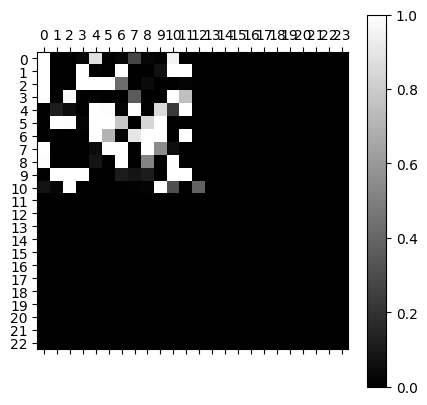

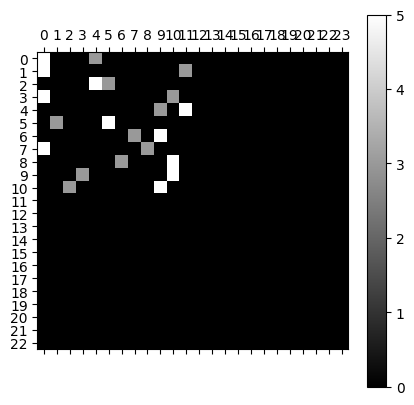

69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/st ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/st ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/st ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/st ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/st ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/st ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/st ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/st ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/st ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/st ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/st ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/st ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/st ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/st ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/st ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/st ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/st ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/st ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/st ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/st ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/st ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/st ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/st ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/st ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/st ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/st ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/ste ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/ste ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/ste ━━━

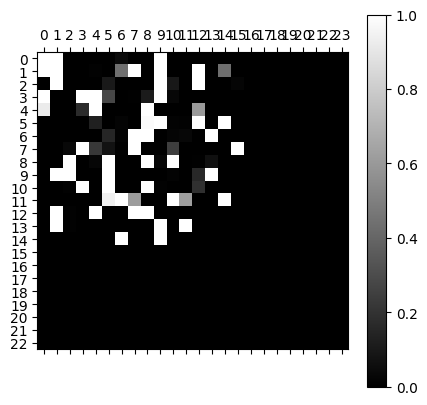

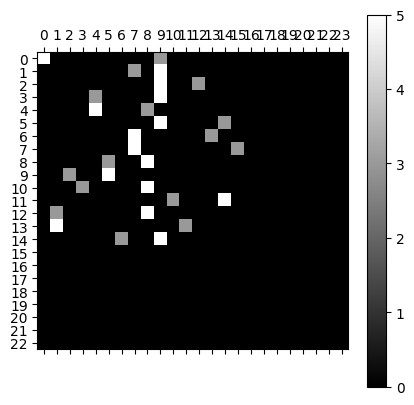

 Resultados 
[-55.0, -75.0]
[]
[72.0, 92.0]
164.0
34
0.0


In [121]:
results =[]
interval=2

# def ajustar_celdas_por_indices(df):
#     df_nuevo = pd.DataFrame(0, index=df.index, columns=df.columns)
#     for idx in df.index:
#         fila = df.loc[idx]
#         top_values = fila.nlargest(2)
#         if len(top_values) > 0:
#             suma_top_values = top_values.sum() 
#             if suma_top_values > 1.9 and suma_top_values < 1.7 :
#                 top_indices = top_values.index
#                 if len(top_indices) > 0:
#                     df_nuevo.loc[idx, top_indices[0]] = 2
#                 if len(top_indices) > 1:
#                     df_nuevo.loc[idx, top_indices[1]] = 1
#     return df_nuevo


def ajustar_celdas_por_indices(df):
    df_nuevo = pd.DataFrame(0, index=df.index, columns=df.columns)
    for idx in df.index:
        fila = df.loc[idx]
        mejor_suma = -np.inf
        mejor_indices = (None, None)
        
        # Buscar las mejores parejas de celdas
        for i in range(len(fila)):
            for j in range(i + 1, len(fila)):
                suma = fila.iloc[i] + fila.iloc[j]
                if 1 < suma <= 1.8 and abs(1.8 - suma) < abs(1.8 - mejor_suma):
                    mejor_suma = suma
                    mejor_indices = (fila.index[i], fila.index[j])
                    continue
        
        # Si se encuentra una buena pareja, asignar los valores
        if mejor_indices != (None, None):
            idx1, idx2 = mejor_indices
            if fila[idx1] > fila[idx2]:
                df_nuevo.loc[idx, idx1] = 2
                df_nuevo.loc[idx, idx2] = 1
            else:
                df_nuevo.loc[idx, idx1] = 1
                df_nuevo.loc[idx, idx2] = 2
                
    return df_nuevo

# models = {
#         "model_lstm_cnn_dens3b":model_lstm_cnn_dense3,
#         "model_lstm_cnn_dense4" :  model_lstm_cnn_dense4
#         }
models = {
        "model_lstm_cnn-mask-zeros-001G":model_lstm_cnn_dense,
        }

type_output = 2
number_eval = int(len(X_test)/3)

print("*************** Validacion modelos ******************")
print(f"************ Casos de pruebas  {number_eval} *******")
number_eval = 2
for model_name , model_val in models.items() :
    print(f" modelo evaluado {model_name}")
    results = []
    for index in range(number_eval) : 
        predicted_image = model_val.predict(X_test)
        test_image = predicted_image[index][interval]

        data_out = []
        for i in range(test_image.shape[0]):
            row = []
            for j in range(test_image.shape[1]):
                # val = 1 if np.abs((test_image[i, j])) > 0.4 else 0
                val = test_image[i, j]
                row.append(val)
            data_out.append(row)

        df_topo_out = pd.DataFrame(data_out, columns=[f'{i}' for i in range(test_image.shape[1])])
        print(df_topo_out)
        print_bw_matrix(df_topo_out)
        df_topo_out = ajustar_celdas_por_indices(df_topo_out)
        # plot_and_print_result(df_topo_out,type_output=type_output)


        test_image_val = Y_test[index][interval]
        data_val = []
        for i in range(test_image_val.shape[0]):
            row = []
            for j in range(test_image_val.shape[1]):
                row.append(np.abs(np.round(test_image_val[i, j])))
            data_val.append(row)

        df_topo_val = pd.DataFrame(data_val, columns=[f'{i}' for i in range(test_image_val.shape[1])])

        plot_and_print_result(df_topo_val ,"Test Model Data",type_output=type_output)
        result = comparar_matrices(df_topo_out,df_topo_val)
        results.append(result)

    val_reuslt = ([True for result in results if result == lines])
    val_reuslt_sum = ([lines-result for result in results ])
    print("="*30)
    print(" Resultados ")
    print((results))
    print((val_reuslt))
    print((val_reuslt_sum))
    print(sum(val_reuslt_sum))
    print(len(results)*lines)
    print(len(val_reuslt)/len(results))
    print("="*30)

In [89]:
import joblib
model_output_path ="../Modelos/{}"

if not os.path.exists(model_output_path.format("")):
    os.makedirs(model_output_path.format(""))

for model_name , model in models.items():
    file_moldel = model_output_path.format(model_name)
    joblib.dump(model,file_moldel)